## Выпускной проект: Определение оптимальной температуры стали



Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.
____

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).
____

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).
____

### План работы:
<a href='#section1'></a>  
1. [Проведём исследовательский анализ данных;](#section1)  
    1.1 [Электроды;](#section1.1)  
    1.2 [Сыпучие материалы (объём);](#section1.2)  
    1.3 [Сыпучие материалы (время);](#section1.3)  
    1.4 [Газ](#section1.4)  
    1.5 [Температура](#section1.5)  
    1.6 [Проволочные материалы (объём);](#section1.6)  
    1.7 [Проволочные материалы (время);](#section1.7)  
    1.8 [Выводы исследовательского анализа.](#section1.8)  
<a href='#section2'></a>  
2. [Проведём предобработку данных](#section2)  
    2.1 [Следствия исследовательского анализа](#section2.1)  
    2.2 [Выделение необходимых признаков для модели;](#section2.2)  
    2.3 [Объединениe данных в единый датафрейм;](#section2.3)  
    2.4 [Масштабирование данных;](#section2.4)  
    2.5 [Выделение тренировочной и тестовой выборки;](#section2.5)  
    2.6 [Выводы по предобработке данных.](#section2.6)  
<a href='#section3'></a>  
3. [Обучим следующие модели:](#section3)   
    * [LinearRegression;](#section3.1)   
    * [XGBoost;](#section3.2)  
    * [LightGBM;](#section3.3)  
    * [CatBoost.](#section3.4)  
<a href='#section4'></a>
4. [Выделим наилучшую модель на тренировочной выборке](#section4)  
<a href='#section5'></a>
5. [Проверим модель на тестовой выборке;](#section5)  
<a href='#section6'></a>
6. [Выводы работы.](#section6)  
<a href='#section7'></a>
7. [Отчёт по работе](#section7)
_____
_____

<a id='section1'></a>
## 1. Исследовательный анализ данных

Импорт инструментов

In [2]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from time import time

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("darkgrid")

C:\Anaconda3\envs\practicum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Загрузка данных

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [4]:
def first_look(data):
    data.info()
    display(data.describe())
    print("Число дубликатов:", data.duplicated().sum())
    print("Количество партий:", data["key"].nunique())
    display(data.head(10))

<a id='section1.1'></a>
### 1.1 Электроды

In [5]:
first_look(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Число дубликатов: 0
Количество партий: 3214


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


* Изменим тип у `Начало нагрева дугой`, `Конец нагрева дугой`;
* Пропусков и дубликотов нет;
* Избавимся от отрицательных значений в столбце `Реактивная мощность`;
* В партии несколько этапов нагревания.

In [6]:
data_arc["Начало нагрева дугой"] = pd.to_datetime(data_arc["Начало нагрева дугой"])
data_arc["Конец нагрева дугой"] =  pd.to_datetime(data_arc["Конец нагрева дугой"])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Выделим общий признак `Время нагрева дугой` взамен двух.

In [7]:
data_arc["Время нагрева дугой"] = (data_arc["Конец нагрева дугой"] - data_arc["Начало нагрева дугой"]).dt.seconds
data_arc.drop(["Конец нагрева дугой", "Начало нагрева дугой"], axis=1, inplace=True)
data_arc.head()

,key,Активная мощность,Реактивная мощность,Время нагрева дугой
0,1,0.976059,0.687084,228
1,1,0.805607,0.520285,185
2,1,0.744363,0.498805,172
3,1,1.659363,1.062669,365
4,1,0.692755,0.414397,148


In [8]:
data_arc = data_arc[data_arc["Реактивная мощность"] >= 0]

Функция для дальнейших построений распределений

In [9]:
def view_distribution(data, column, *arg):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1], "hspace" : 0.3}, dpi=160)
    # Left
    sns.distplot(data[column], ax=ax1)
    ax1.set_title("Распределение: " + column)
    # Right
    ax2.set_title("Диаграмма размаха")
    sns.boxplot(data[column], ax=ax2)

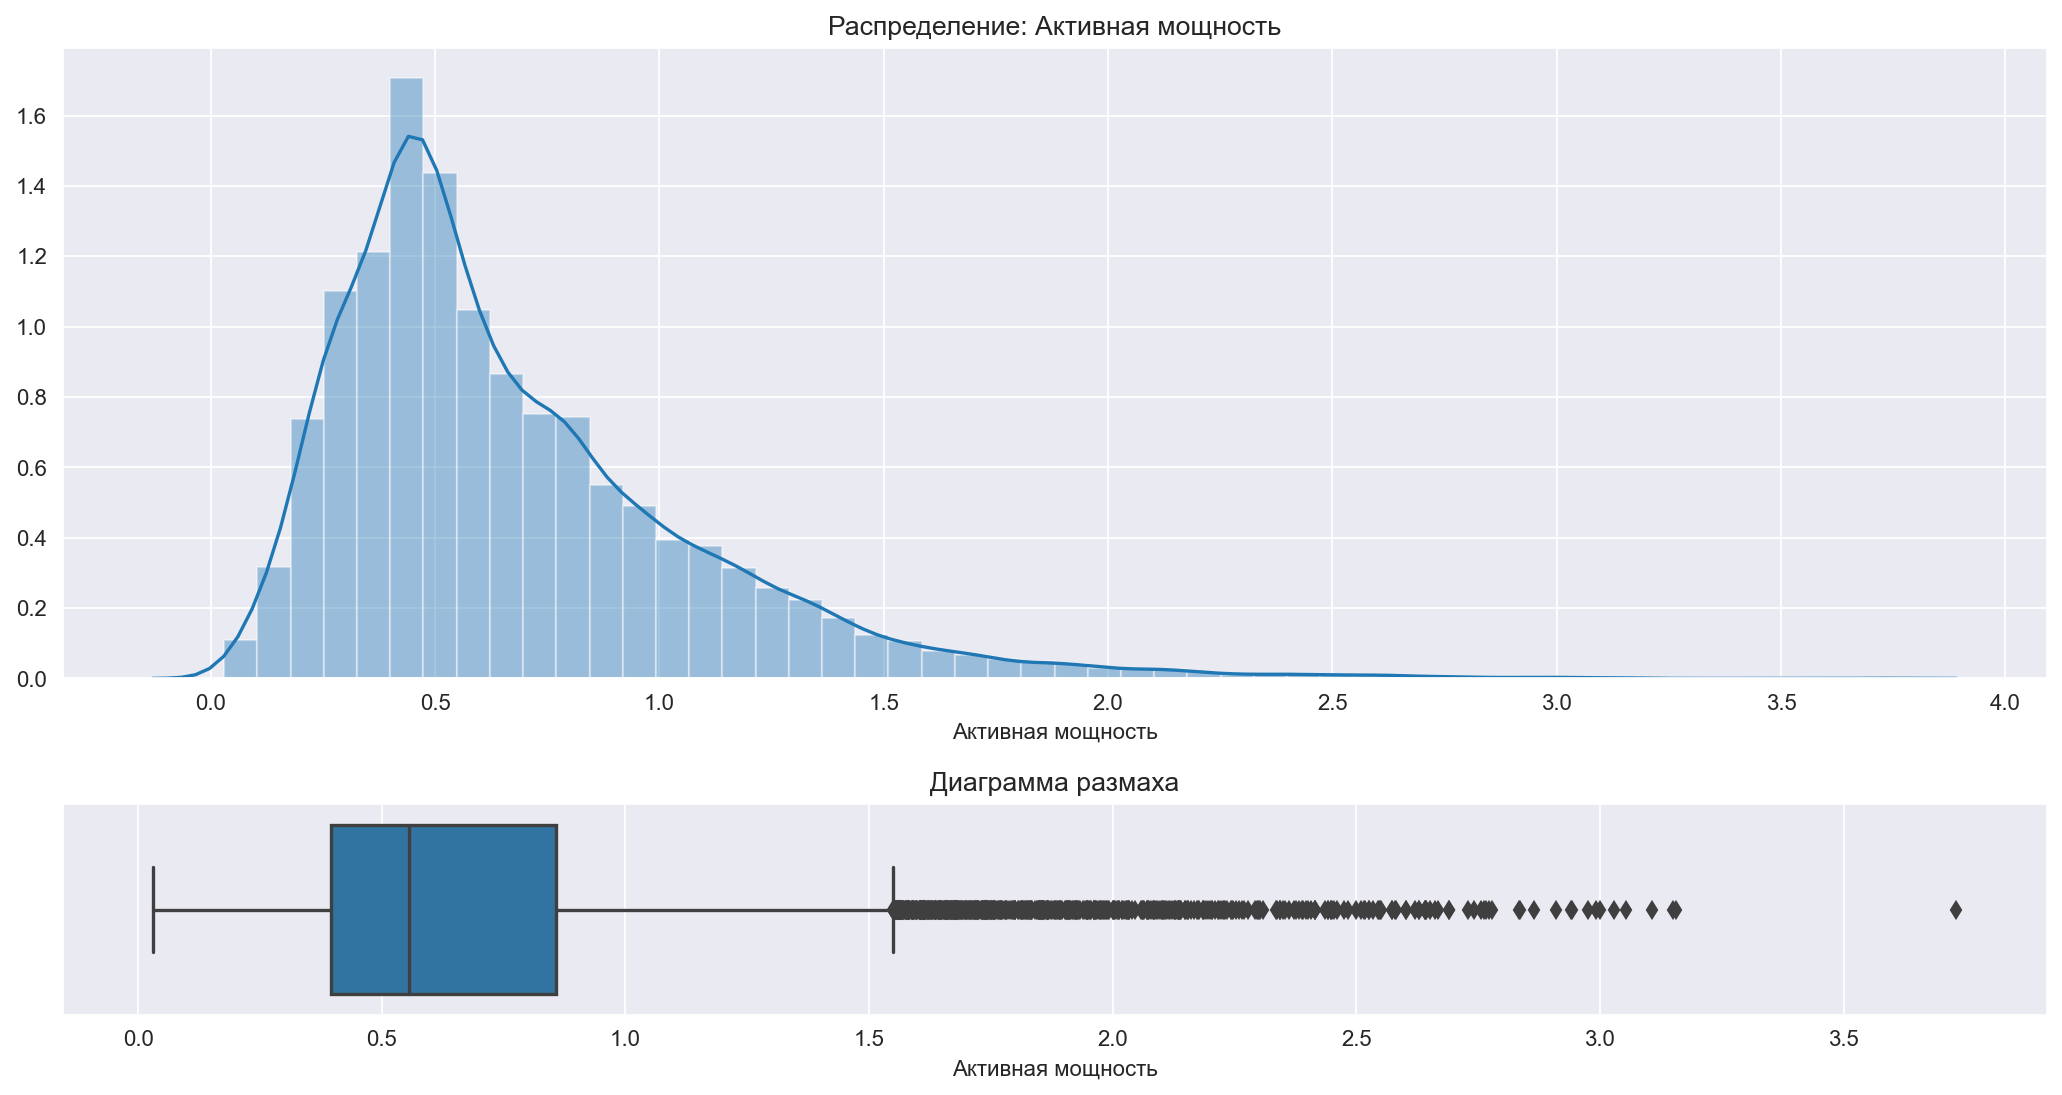

In [10]:
view_distribution(data_arc, "Активная мощность")

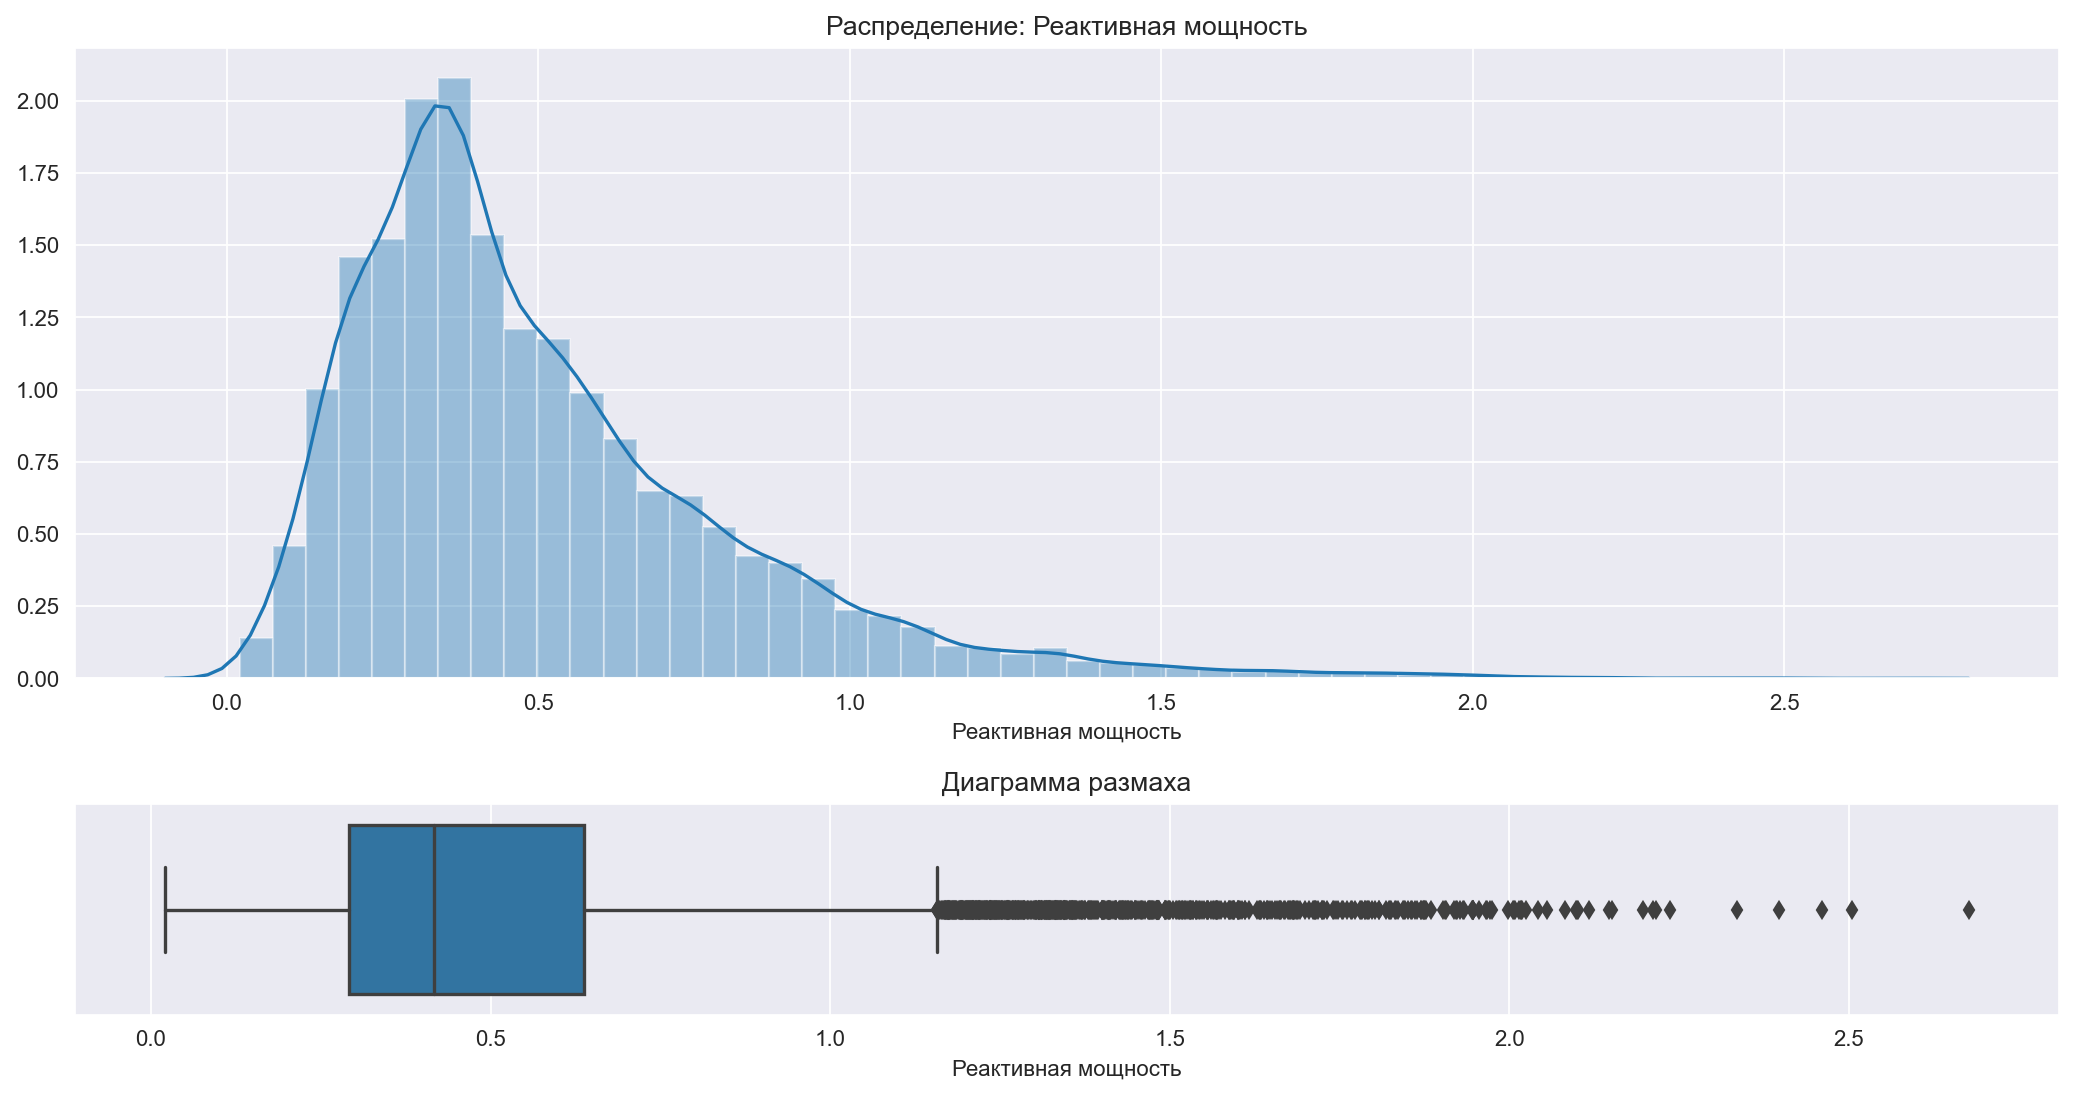

In [11]:
view_distribution(data_arc, "Реактивная мощность")

Данные очень похожи между собой. Нормально распределённые со смещением влево.
Проверим их на взаимозависимость.

In [12]:
print("Коэффициент корреляции активной и реактивной мощностей =", 
      data_arc["Активная мощность"].corr(data_arc["Реактивная мощность"]).round(2))

Коэффициент корреляции активной и реактивной мощностей = 0.96


Можем оставить одну их них или заменить на полную мощность:
\begin{equation}
    \vec{S} = \vec{P} + \vec{Q},
\end{equation}
где $Q$ - реактивная мощность, $P$ - активная мощность

In [13]:
def full_power(x): return np.sqrt(x["Реактивная мощность"]**2 + x["Активная мощность"]**2)

In [14]:
data_arc["Полная мощность"] = data_arc.apply(full_power, axis=1)
data_arc.drop(["Реактивная мощность", "Активная мощность"], axis=1, inplace=True)
data_arc.head()

,key,Время нагрева дугой,Полная мощность
0,1,228,1.193639
1,1,185,0.959010
2,1,172,0.896038
3,1,365,1.970470
4,1,148,0.807239


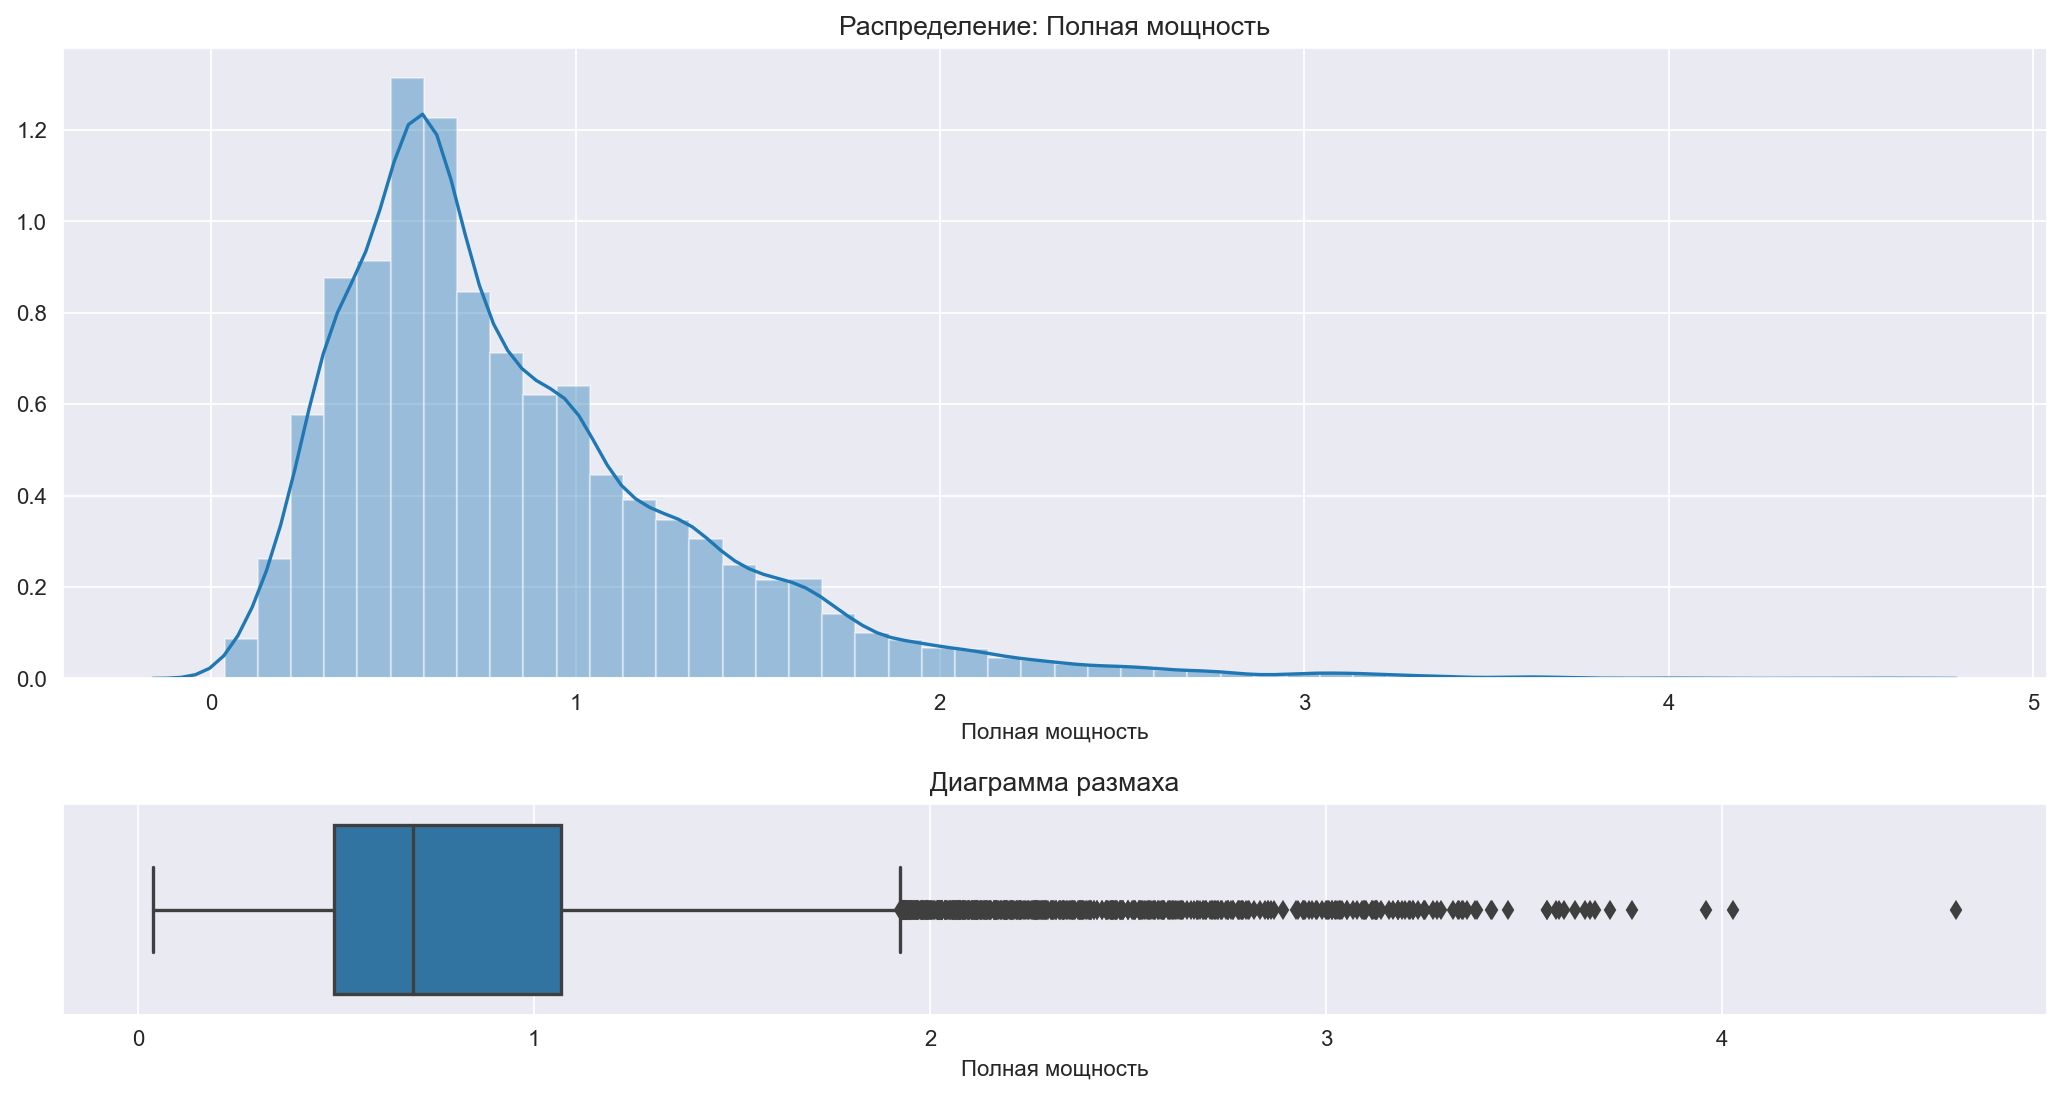

In [15]:
view_distribution(data_arc, "Полная мощность")

<a id='section1.2'></a>
### 1.2 Сыпучие материалы (объём)

In [16]:
first_look(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Число дубликатов: 0
Количество партий: 3129


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


* Дубликаты отсутвуют;
* Много пропусков в данных. Следствие зависимости отдельно взятой партии от комбинации сыпучих материалов.

<a id='section1.3'></a>
### 1.3 Сыпучие материалы (время)

In [17]:
first_look(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Число дубликатов: 0
Количество партий: 3129


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


* Дубликаты отсутствуют;
* Аналогичные пункту 1.3 причины пропусков;
* Задача не заточена на работу с временными рядами => в дальнейшнем не используем.

<a id='section1.4'></a>
### 1.4 Газ

In [18]:
first_look(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Число дубликатов: 0
Количество партий: 3239


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


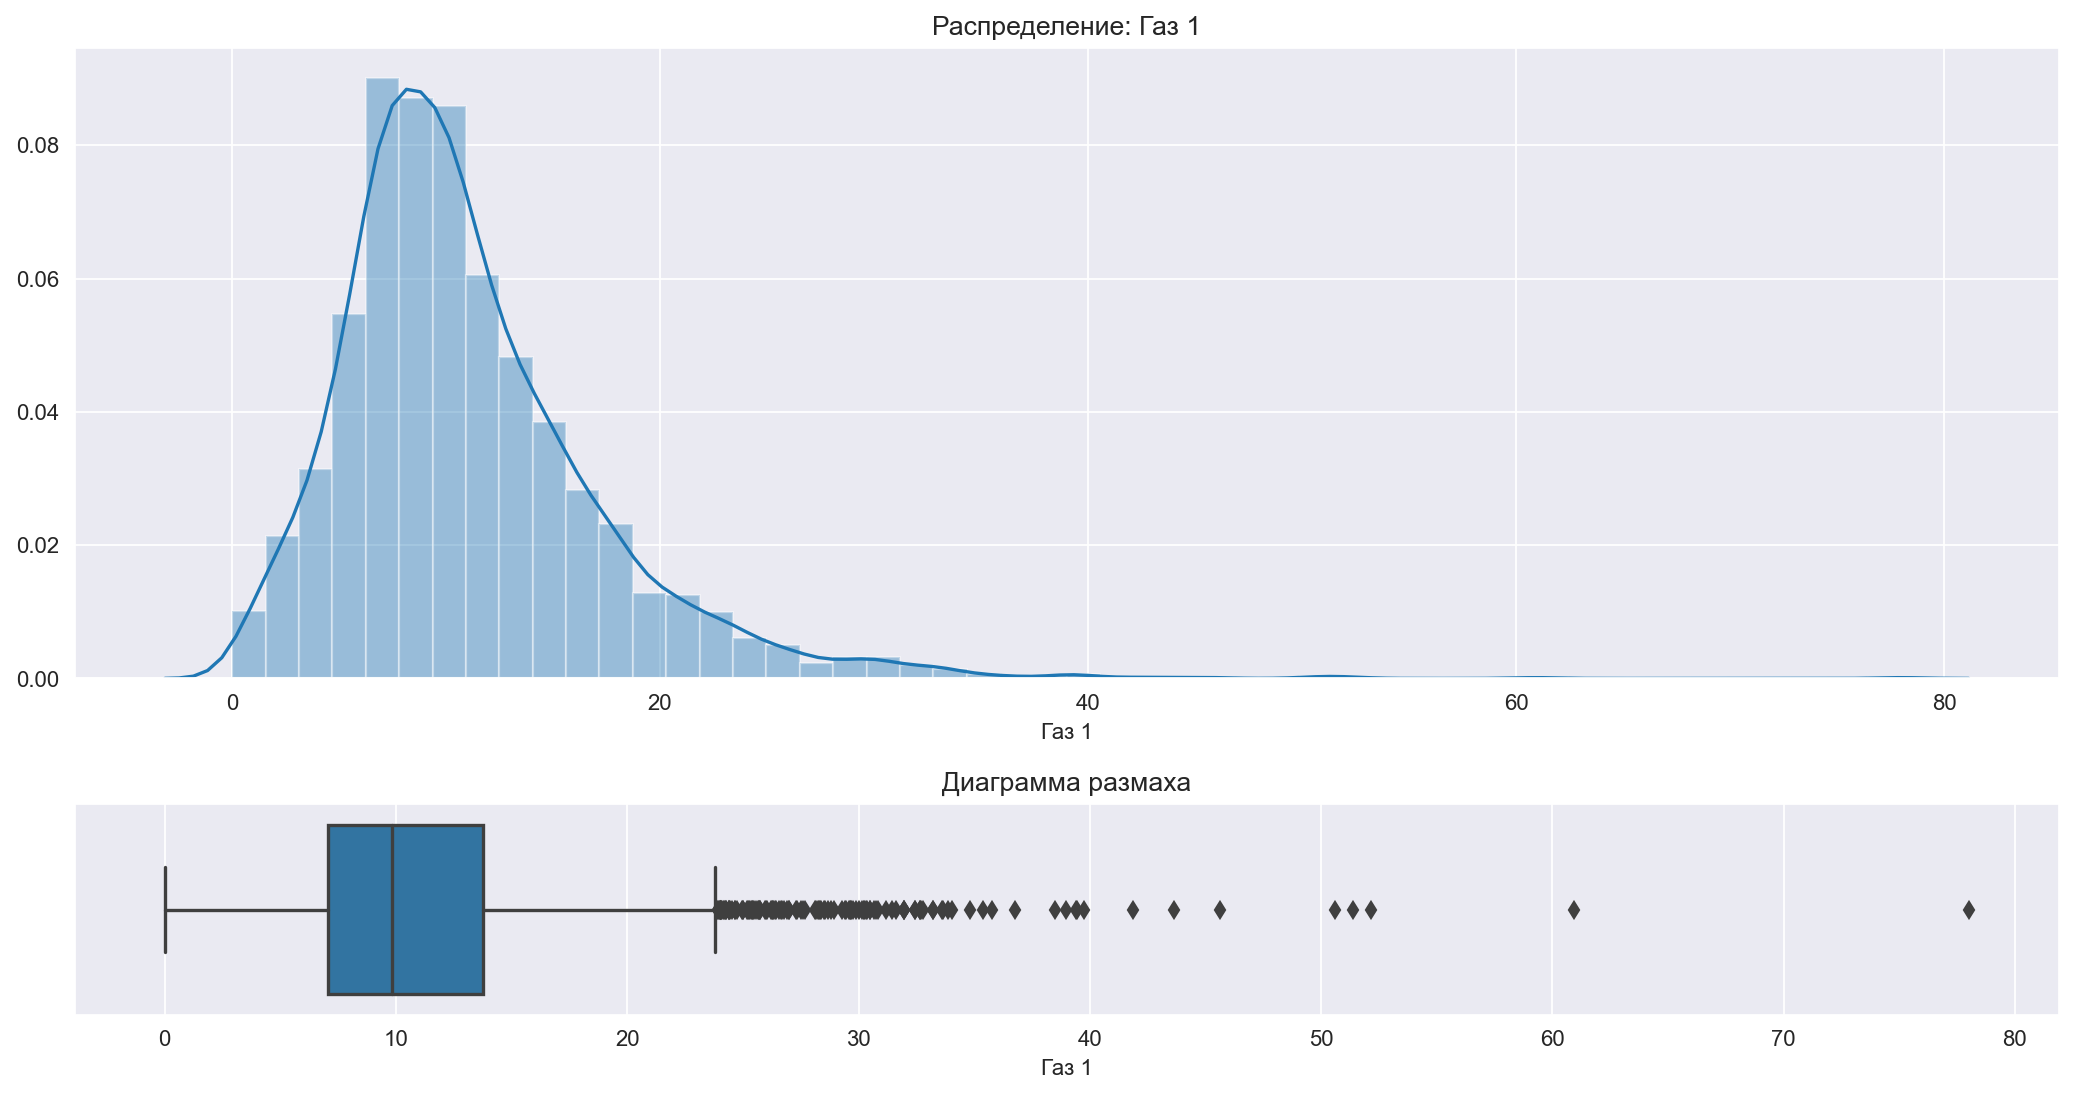

In [19]:
view_distribution(data_gas, "Газ 1")

* Дубликаты и пропуски отсутствуют;
* Нормальное со смещением влево распределение данных.

<a id='section1.5'></a>
### 1.5 Температура

In [20]:
first_look(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Число дубликатов: 0
Количество партий: 3216


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


* Дубликаты отсутствуют;
* Пропуски в столбце `Температура`;
* Неверный тип данных в столбце `Время замера`;

In [21]:
data_temp["Время замера"] = pd.to_datetime(data_temp["Время замера"])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [22]:
temp_nans = data_temp[data_temp["Температура"].isna()]
temp_nans.head()

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


In [23]:
temp_nans["key"].is_monotonic

True

Отсутствуют данные о температуре, начиная с `2500` партии.

<a id='section1.6'></a>
### 1.6 Проволочные материалы (объём)

In [24]:
first_look(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Число дубликатов: 0
Количество партий: 3081


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Дубликаты отсутствуют;
* Природа пропусков аналогична пропускам в данных, касающихся сыпучих материалов, - зависимость от партии к партии.

<a id='section1.7'></a>
### 1.7 Проволочные материалы (время)

In [25]:
first_look(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Число дубликатов: 0
Количество партий: 3081


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Дубликаты отсутствуют;
* Аналогичные пункту 1.6 причины пропусков;
* Задача не заточена на работу с временными рядами => в дальнейшнем не используем.

<a id='section1.8'></a>
### 1.8 Выводы исследовательского анализа

1. Дубликаты в данных отсутствуют;
2. Очищены аномалии в значениях реактивной мощности;
3. Выделили новый признак `Время нагрева дугой`;
4. Выявлена взаимозависимость с коэффициентом корреляции `0,96` между реактивной и активной мощностями. Перешли к новому признаку `Полная мощность`;
5. Данным, отвечающим за время, установлен соответсвтующий тип данных;
6. Установили, что, начиная с `2500` партии, отсутствуют данные о температуре;
7. В партии несколько этапов нагревания.
____

<a id='section2'></a>
## 2. Предобработка данных

In [26]:
data_list = [data_arc, data_bulk, data_gas, data_temp, data_wire]

<a id='section2.1'></a>
### 2.1 Следствие исследовательского анализа

Отбрасываем все партии с `2500`.

In [27]:
data_arc = data_arc.query("key < 2500")
data_bulk = data_bulk.query("key < 2500")
data_gas = data_gas.query("key < 2500")
data_temp = data_temp.query("key < 2500")
data_wire = data_wire.query("key < 2500")

Выделим новый признак: количество нагреваний дугой на партию.

In [28]:
data_arc_key = data_arc.groupby(by='key', as_index=False).sum()
data_arc_session = (
    pd.pivot_table(
        data = data_arc,
        index = "key",
        aggfunc = "count",
    ).reset_index()
     .drop("Полная мощность", axis=1)
     .rename(columns={"Время нагрева дугой" : "Количество сессий нагрева"})
)
display(data_arc_key.head())
print(data_arc_key.shape)
display(data_arc_session.head())
print(data_arc_session.shape)

,key,Время нагрева дугой,Полная мощность
0,1,1098,5.826395
1,2,811,3.649216
2,3,655,2.989534
3,4,741,3.814962
4,5,869,4.035758


(2475, 3)


,key,Количество сессий нагрева
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


(2475, 2)


In [29]:
data_arc = data_arc_key.merge(data_arc_session, how="left", on="key")
data_arc.head()

,key,Время нагрева дугой,Полная мощность,Количество сессий нагрева
0,1,1098,5.826395,5
1,2,811,3.649216,4
2,3,655,2.989534,5
3,4,741,3.814962,4
4,5,869,4.035758,4


<a id='section2.2'></a>
### 2.2 Выделение необходимых признаков для модели

In [30]:
data_arc.corr()

,key,Время нагрева дугой,Полная мощность,Количество сессий нагрева
key,1.000000,-0.034212,-0.022532,-0.034834
Время нагрева дугой,-0.034212,1.000000,0.982899,0.795958
Полная мощность,-0.022532,0.982899,1.000000,0.760402
Количество сессий нагрева,-0.034834,0.795958,0.760402,1.000000


`Время нагрева дугой` и `Полная мощность` - взаимозаменяемые признаки из-за сильной корреляции `0,98`.

In [31]:
data_arc.drop("Время нагрева дугой", axis=1, inplace=True)
data_arc.head()

,key,Полная мощность,Количество сессий нагрева
0,1,5.826395,5
1,2,3.649216,4
2,3,2.989534,5
3,4,3.814962,4
4,5,4.035758,4


Выделим признак последнего измерения температуры в партии.
Для этого 
* сгруппируем данные температуры по партии;
* выделим первое и последнее значения температуры.

In [32]:
data_temp = data_temp.pivot_table(
    index = "key",
    aggfunc = ["first", "last"]
).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.drop("Время замера", axis=1, inplace=True)
data_temp.columns = ["key", "Температура 1", "Температура 2"]
data_temp.head()

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


<a id='section2.3'></a>
### 2.3 Объединениe данных в единый датафрейм

In [33]:
data = (data_arc.merge(data_bulk, how = "left", on = "key")
                 .merge(data_gas, how = "left", on = "key")
                 .merge(data_temp, how = "left", on = "key")
                 .merge(data_wire, how = "left", on = "key")
       )
data.drop("key", axis=1, inplace=True)
data = data.fillna(0)
data.shape

(2475, 29)

In [34]:
rename_dict = {
    "Полная мощность" : "Full power",
    "Количество сессий нагрева" : "Heating sessions",
    "Газ 1" : "Gas",
    "Температура 1" : "Temperature 1",
    "Температура 2" : "Temperature 2"
}

data = data.rename(columns=rename_dict)
data.head()

,Full power,Heating sessions,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Temperature 2,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,5.826395,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.649216,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.989534,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.814962,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.035758,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='section2.4'></a>
### 2.4 Выделение тренировочной и тестовой выборок

In [35]:
target = data["Temperature 2"]
features = data.drop("Temperature 2", axis=1)
features.columns

Index(['Full power', 'Heating sessions', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Gas',
       'Temperature 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
       'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [36]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=314)
features_train.shape, features_test.shape

((1856, 28), (619, 28))

<a id='section2.5'></a>
### 2.5 Масштабирование данных

In [37]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

<a id='section2.6'></a>
### 2.6 Выводы по предобработке данных

1. Исправлены проблемы, найденные в исследовательском анализе;
2. Выделен новый признак: `Количество сессий нагрева дугой`;
3. Обработаны пропуски в данных сыпучих и проволочных материалов;
4. Проведено масштабирование признаков;
5. Выделена тренировочная и тестовая выборки.
____

<a id='section3'></a>
## 3 Обучение моделей

In [39]:
class model:
    RANDOM_STATE = 314
    MODELS = {
        "LinearRegression" : LinearRegression(),
        "XGBoost" : xgb.XGBRegressor(),
        "LightGBM" : lgb.LGBMRegressor(),
        "CatBoost" : CatBoostRegressor()
    }
    PARAMS = {
        "LinearRegression" : {
            "fit_intercept" : [True, False],
            "normalize" : [True, False]
        },
        "XGBoost" : {
            'min_child_weight': np.arange(10, 30, 5),
            'gamma': [5],
            'n_estimators' : np.arange(100, 501, 100),
            'subsample': [1.0],
            'colsample_bytree': [1.0],
            'max_depth': np.arange(5, 15, 2),
            'eval_metric' :['mae']
        },
        "LightGBM" : {
            'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
            'objective': ['regression'],
            'learning_rate': np.arange(0.07, 0.14, 0.02),
            'num_iterations':[500],
            'random_state': [RANDOM_STATE], 
            'max_depth': np.arange(2, 10),
            'metric': ['mae']
        },
        "CatBoost" : {
          'loss_function':['MAE'],
          'n_estimators': np.arange(300, 901, 100),  
          'learning_rate': np.arange(0.07, 0.14, 0.02),
          'random_state':[RANDOM_STATE],
          'depth': np.arange(3, 5),
          'l2_leaf_reg' : [1, 3, 5, 7]
    }
    }
    
    def __init__(self, name):
        try:
            self.model = self.MODELS[name]
            self.name = name
        except KeyError:
            print("Wrong input: model name")
            
    def fit(self, features_train, target_train):
        start_time = time()
        search = GridSearchCV(
            estimator = self.model,
            param_grid = self.PARAMS[self.name],
            cv = 5,
            verbose = 1,
            n_jobs= -1,
            return_train_score = True
        )
        search.fit(features_train, target_train)
        self.search_time = time() - start_time
        self.train_results = search.cv_results_
        self.best_estimator = search.best_estimator_
        self.best_params = search.best_params_
        
        # Train on best estimator
        self.train_predictions = search.predict(features_train)
        self.train_mae = mae(target_train, self.train_predictions)

    def predict(self, features_test, target_test):
        start_time = time()
        self.predictions = self.best_estimator.predict(features_test)
        self.test_mae = mae(target_test, self.predictions)
        
# ----- Return results -----
    def get_results(self):
        data = {
            "Model name" : [self.name], 
            "GridSearch time" : [self.search_time], 
            "Best estimator" : [self.best_estimator], 
            "Best parameters" : [self.best_params], 
            "Train mae" : [self.train_mae]
        }
        return pd.DataFrame(data)
    
# ----- Visualization -----
    def view_feature_importances(self, features_names):

        feature_importances = self.best_estimator.feature_importances_

        #Create a DataFrame using a Dictionary
        data={
            "name" : features_names,
            "importance" : feature_importances
        }
        plot_data = pd.DataFrame(data).sort_values(by="importance", ascending=False)

        fig, ax = plt.subplots(figsize=(12,12), dpi=180)
        sns.barplot(x=plot_data["importance"], y=plot_data["name"], ax=ax)
        ax.set_title(self.name + " feature importances", fontsize=14)
        ax.set_xlabel("Importance value", fontsize=12)
        ax.set_ylabel("Feature name", fontsize=12)
        ax.grid()

In [39]:
results = []

<a id='section3.1'></a>
### 3.1 LinearRegression

In [40]:
lr = model("LinearRegression")

In [41]:
%%time

lr.fit(features_train, target_train)
results.append(lr.get_results())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Wall time: 2.94 s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished


<a id='section3.2'></a>
### 3.2 XGBoost

In [42]:
xgb_reg = model("XGBoost")

In [43]:
%%time

xgb_reg.fit(features_train, target_train)
results.append(xgb_reg.get_results())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.1min finished
Wall time: 4min 8s


<a id='section3.3'></a>
### 3.3 LightGBM

In [44]:
lgb_reg = model("LightGBM")

In [45]:
%%time

lgb_reg.fit(features_train, target_train)
results.append(lgb_reg.get_results())

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
Wall time: 3min 30s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  3.5min finished


<a id='section3.4'></a>
### 3.4 CatBoost

In [46]:
cat_reg = model("CatBoost")

In [47]:
%%time

cat_reg.fit(features_train, target_train)
results.append(cat_reg.get_results())

ng: 816ms
516:	learn: 4.9114204	total: 1.1s	remaining: 813ms
517:	learn: 4.9106201	total: 1.1s	remaining: 810ms
518:	learn: 4.9092183	total: 1.1s	remaining: 808ms
519:	learn: 4.9081550	total: 1.1s	remaining: 805ms
520:	learn: 4.9056066	total: 1.1s	remaining: 803ms
521:	learn: 4.9031969	total: 1.1s	remaining: 801ms
522:	learn: 4.9028460	total: 1.11s	remaining: 798ms
523:	learn: 4.8995140	total: 1.11s	remaining: 796ms
524:	learn: 4.8982205	total: 1.11s	remaining: 794ms
525:	learn: 4.8977643	total: 1.11s	remaining: 791ms
526:	learn: 4.8954201	total: 1.11s	remaining: 789ms
527:	learn: 4.8944578	total: 1.11s	remaining: 786ms
528:	learn: 4.8936079	total: 1.12s	remaining: 784ms
529:	learn: 4.8934299	total: 1.12s	remaining: 781ms
530:	learn: 4.8925323	total: 1.12s	remaining: 779ms
531:	learn: 4.8907205	total: 1.12s	remaining: 777ms
532:	learn: 4.8890454	total: 1.13s	remaining: 775ms
533:	learn: 4.8876264	total: 1.13s	remaining: 773ms
534:	learn: 4.8875719	total: 1.13s	remaining: 771ms
535:	lea

_______________________

<a id='section4'></a>
## 4. Выделим наилучшую модель на тренировочной выборке

In [48]:
def view_results(report):    
    return (report
        .style
        .highlight_min(color='orange')
        .highlight_max(color='lightgreen')
    )

In [49]:
train_report = pd.concat(results).reset_index(drop=True)
view_results(train_report)

,Model name,GridSearch time,Best estimator,Best parameters,Train mae
0,LinearRegression,2.938514,LinearRegression(),"{'fit_intercept': True, 'normalize': False}",7.964069
1,XGBoost,248.068414,"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0, eval_metric='mae', gamma=5, gpu_id=-1, importance_type='gain', interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=5, min_child_weight=25, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0, tree_method='exact', validate_parameters=1, verbosity=None)","{'colsample_bytree': 1.0, 'eval_metric': 'mae', 'gamma': 5, 'max_depth': 5, 'min_child_weight': 25, 'n_estimators': 100, 'subsample': 1.0}",3.467422
2,LightGBM,210.361787,"LGBMRegressor(learning_rate=0.09000000000000001, max_depth=2, metric='mae', num_iterations=500, objective='regression', random_state=314)","{'boosting_type': 'gbdt', 'learning_rate': 0.09000000000000001, 'max_depth': 2, 'metric': 'mae', 'num_iterations': 500, 'objective': 'regression', 'random_state': 314}",5.082957
3,CatBoost,647.092745,,"{'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.07, 'loss_function': 'MAE', 'n_estimators': 900, 'random_state': 314}",4.574646


Наилучшие результаты на обучении показали модели: `XGBoostRegressor` и `CatBoostRegressor`.

<a id='section5'></a>
## 5. Проверка на тестовой выборке

In [50]:
xgb_best = xgb_reg.best_estimator
cat_best = cat_reg.best_estimator

In [51]:
xgb_predictions = xgb_best.predict(features_test)
cat_predictions = cat_best.predict(features_test)
print(
    f"XGBoostRegressor`s mae = {round(mae(target_test, xgb_predictions), 4)}\n",
    f"CatBoostRegressor`s mae = {round(mae(target_test, cat_predictions), 4)}",
    sep=''
)

XGBoostRegressor`s mae = 6.5395
CatBoostRegressor`s mae = 6.0875


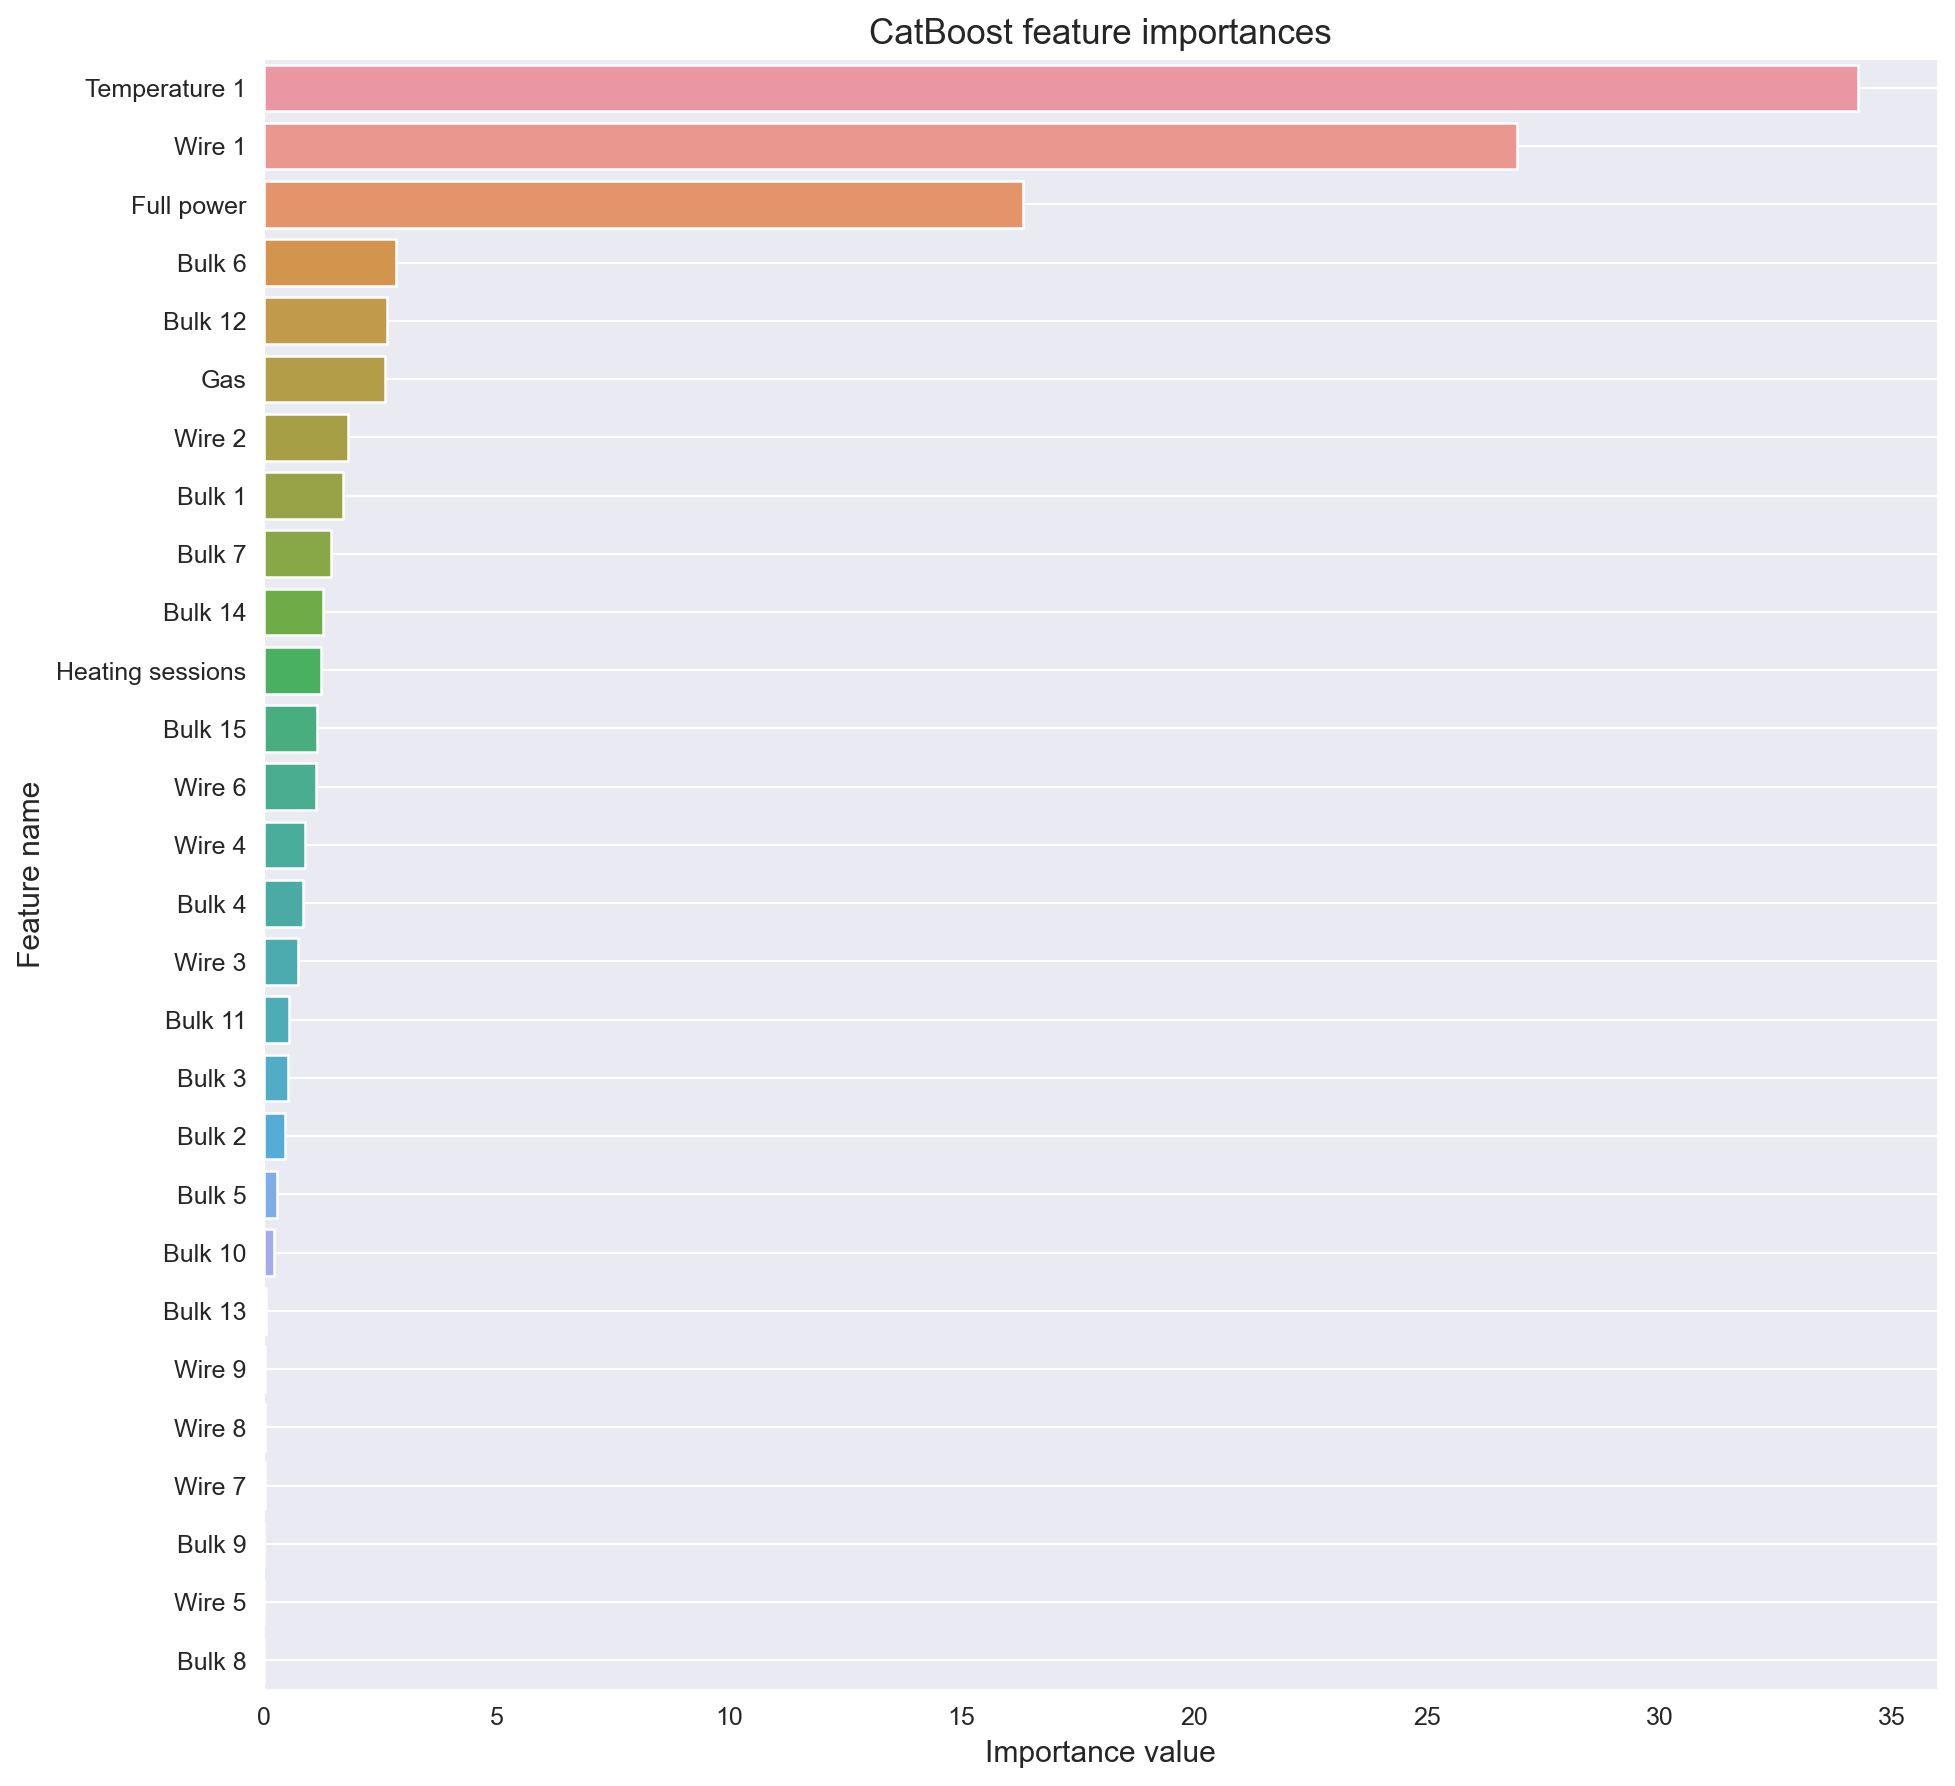

In [52]:
cat_reg.view_feature_importances(features_names=features.columns)

Значение по метрике < 6.0 не пробито => попробуем исключить малозначимые признаки: `Bulk 13`, `Wire 9`, `Wire 8`, `Wire 7`, `Bulk 9`, `Wire 5`, `Bulk 8`, - и обучить повторно.

In [61]:
data_2 = data.copy()
non_features = [
    'Bulk 13', 'Wire 9', 'Wire 8', 'Wire 7', 'Bulk 9', 'Wire 5', 'Bulk 8',
    'Bulk 3', 'Bulk 2', 'Bulk 5'
]

target = data_2["Temperature 2"]
features = data_2.drop(non_features + ["Temperature 2"], axis=1)
features.columns

Index(['Full power', 'Heating sessions', 'Bulk 1', 'Bulk 4', 'Bulk 6',
       'Bulk 7', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Gas',
       'Temperature 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6'],
      dtype='object')

In [62]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=314)
features_train.shape, features_test.shape

((1856, 18), (619, 18))

In [63]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [64]:
cat_2 = model("CatBoost")

In [ ]:
%%time

# Train
cat_2.fit(features_train, target_train)
display(cat_2.get_results())

In [60]:
# Test
cat_best_2 = cat_2.best_estimator
cat_predictions_2 = cat_best_2.predict(features_test)
print(f"CatBoostRegressor`s mae = {round(mae(target_test, cat_predictions_2), 4)}", sep='')

AttributeError: 'model' object has no attribute 'best_estimator'

In [ ]:
cat_2.view_feature_importances(features_names=features.columns)

<a id='section6'></a>
## 6. Выводы работы

1. Был проведён исследовательский анализ данных;
2. Произведена обработка данных от пропусков и мультиколлинеарности признаков;
3. Добавлены новые признаки;
4. Обучены с подбором гиперпараментров средствами `GridSearchCV` следующие модели: `LinearRegression`, `XGBoostRegressor`,
`LGBMRegressor`, `CatBoostRegressor`;
5. На тестовой выборке с помощью модели `CatBoostRegressor` было достигнуто значение `MAE = 6.09`;
6. Наиболее влиятельными на результат оказались признаки:
    * Начальная температура;
    * Количество `Wire 1`;
    * Полная мощность.

<a id='section7'></a>
## 7. Отчёт по работе

1. *Какие пункты плана были выполнены, а какие — нет (поясните почему)?*
Выполнены были все заранее спланированные пункты.
2. *Какие трудности возникли и как вы их преодолели?*
    * Корректно обработать данные (отсев всех партий с номером большим 2500);
    * Пробитие метрики МАЕ на тестовой выборке < 6.0 — неудачно;
3. *Какие ключевые шаги в решении задачи выделили?*
    * Определение необходимости тех или иных выборок среди предоставленных;
    * Обработка взаимозависимых признаков и выделение новых на их основе, например, выделение количества итераций нагрева; 
    * Корректное слияние данных в единый датасет;
4. *Какая ваша итоговая модель и какое у неё качество?*  
**Итоговая модель:** `CatBoostRegressor`  
**Качество по МАЕ:** `6.09`.